# Cleaning: LL17


 'CH14-CH15' based on bipolar reading


### Prep

In [2]:
import matplotlib
matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
import os
import mne
import IPython
import seaborn as sns

In [2]:
%matplotlib qt5

In [3]:
# helper functions#

def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])
        
def find_bad_trial_times(idx, srate, trial_begins, trial_lengths):
    ''' takes and index of trial lengths, beginnings and the sampling rate and returns the the start time and and
    duration of the times to annotae as BAD '''
    start_time = trial_begins[0][idx]/srate
    duration = trial_lengths[0][idx]/srate
    
    return start_time, duration        

In [4]:
## Prep paths ##

subject = 'LL17'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [5]:
## Load Data ##

raw_fif = mne.io.Raw(f"{raw_data_dir}/ieeg/{subject}_raw_ieeg.fif")

Opening raw data file /home/brooke/pacman/raw_data/LL17/ieeg/LL17_raw_ieeg.fif...
    Range : 0 ... 982099 =      0.000 ...  1918.162 secs
Ready.


In [21]:
## Filtering ##

# load data #
raw_fif.load_data()

# highpass filter @ 1 and lowpass @ 200 #
filtered_data = raw_fif.filter(l_freq=1, h_freq=100) # skip this step for TF analysis, always do this on the least processed data, or do .1 to 250

# remove 60hz line noise #
freqs = (60, 120, 180, 240)
filtered_notch_data = filtered_data.notch_filter(freqs=freqs) 


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 sec)



[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:    2.4s finished


In [6]:
## Load/Save Filtered Data ##

# save #
# filtered_notch_data.save(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_ieeg.fif", overwrite = True)

# load #
filtered_notch_data = mne.io.Raw(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_ieeg.fif")
events = mne.find_events(filtered_notch_data, output='step', consecutive = False, stim_channel='STI')

Opening raw data file /home/brooke/pacman/raw_data/LL17/ieeg/LL17_notched_filtered_ieeg.fif...
    Range : 0 ... 982099 =      0.000 ...  1918.162 secs
Ready.
504 events found
Event IDs: [0 1]


In [7]:
filtered_notch_data.info['ch_names']

['CH0',
 'CH1',
 'CH2',
 'CH3',
 'CH4',
 'CH5',
 'CH6',
 'CH7',
 'CH8',
 'CH9',
 'CH10',
 'CH11',
 'CH12',
 'CH13',
 'CH14',
 'CH15',
 'CH16',
 'CH17',
 'CH18',
 'CH19',
 'CH20',
 'CH21',
 'CH22',
 'CH23',
 'CH24',
 'CH25',
 'CH26',
 'CH27',
 'CH28',
 'CH29',
 'CH30',
 'CH31',
 'CH32',
 'CH33',
 'CH34',
 'CH35',
 'CH36',
 'CH37',
 'CH38',
 'CH39',
 'CH40',
 'CH41',
 'CH42',
 'CH43',
 'CH44',
 'CH45',
 'CH46',
 'CH47',
 'CH48',
 'CH49',
 'CH50',
 'CH51',
 'CH52',
 'CH53',
 'CH54',
 'CH55',
 'CH56',
 'CH57',
 'CH58',
 'CH59',
 'CH60',
 'CH61',
 'CH62',
 'CH63',
 'CH64',
 'CH65',
 'CH66',
 'CH67',
 'CH68',
 'CH69',
 'CH70',
 'CH71',
 'CH72',
 'CH73',
 'CH74',
 'CH75',
 'CH76',
 'CH77',
 'CH78',
 'CH79',
 'CH80',
 'CH81',
 'CH82',
 'CH83',
 'CH84',
 'CH85',
 'CH86',
 'CH87',
 'CH88',
 'CH89',
 'CH90',
 'CH91',
 'CH92',
 'CH93',
 'CH94',
 'CH95',
 'CH96',
 'CH97',
 'CH98',
 'CH99',
 'CH100',
 'CH101',
 'CH102',
 'CH103',
 'CH104',
 'CH105',
 'CH106',
 'CH107',
 'CH108',
 'CH109',
 'CH110',


## Cleaning Neural Data

#### Bad Channels

Epileptic channels from my cleaning: 

Noisy channels: 

['CH100', 'CH101', 'CH102', 'CH103', 'CH104', 'CH105', 'CH106', 'CH107', 'CH108', 'CH109', 'CH110', 'CH111', 'CH112', 'CH113', 'CH114', 'CH115', 'CH116', 'CH117', 'CH118', 'CH119', 'CH120', 'CH121', 'CH122', 'CH123', 'CH124', 'CH125', 'CH126', 'CH127', 'CH128', 'CH129', 'CH130', 'CH131', 'CH132', 'CH133', 'CH134', 'CH135', 'CH136', 'CH137', 'CH138', 'CH139', 'CH140', 'CH141', 'CH142', 'CH143', 'CH144', 'CH145', 'CH146', 'CH147', 'CH59', 'CH73', 'CH74', 'CH75', 'CH76', 'CH77', 'CH78', 'CH79', 'CH80', 'CH81', 'CH82', 'CH83', 'CH84', 'CH85', 'CH86', 'CH87', 'CH88', 'CH89', 'CH90', 'CH91', 'CH92', 'CH93', 'CH94', 'CH95', 'CH96', 'CH97', 'CH98', 'CH99', 'CH22-CH23', 'CH14-CH15']

In [8]:
# Remove Channels from filtered data

# remove non seeg electrodes electrodes #
string_lst = ['EMPTY', 'REF', 'ekg']

bad_channels_reg = [re.findall(r"(?=("+'|'.join(string_lst)+r"))", name, re.IGNORECASE) for name in filtered_notch_data.info['ch_names']]
bad_channels_index = [i for i,x in enumerate(bad_channels_reg) if  x]
bad_channels = [filtered_notch_data.info['ch_names'][i] for i in bad_channels_index]

filtered_notch_data.info['bads'].extend(bad_channels)  

# # remove epileptic electrodes
filtered_notch_data.info['bads'].extend(['CH59', 'CH22', 'CH23', 'CH14', 'CH15'])  

# remove out of brain electrodes
## TODO hasn't been localized

# remove scalp and dc channels
scalp_dc_channels = ['CH73',
 'CH74',
 'CH75',
 'CH76',
 'CH77',
 'CH78',
 'CH79',
 'CH80',
 'CH81',
 'CH82',
 'CH83',
 'CH84',
 'CH85',
 'CH86',
 'CH87',
 'CH88',
 'CH89',
 'CH90',
 'CH91',
 'CH92',
 'CH93',
 'CH94',
 'CH95',
 'CH96',
 'CH97',
 'CH98',
 'CH99',
 'CH100',
 'CH101',
 'CH102',
 'CH103',
 'CH104',
 'CH105',
 'CH106',
 'CH107',
 'CH108',
 'CH109',
 'CH110',
 'CH111',
 'CH112',
 'CH113',
 'CH114',
 'CH115',
 'CH116',
 'CH117',
 'CH118',
 'CH119',
 'CH120',
 'CH121',
 'CH122',
 'CH123',
 'CH124',
 'CH125',
 'CH126',
 'CH127',
 'CH128',
 'CH129',
 'CH130',
 'CH131',
 'CH132',
 'CH133',
 'CH134',
 'CH135',
 'CH136',
 'CH137',
 'CH138',
 'CH139',
 'CH140',
 'CH141',
 'CH142',
 'CH143',
 'CH144',
 'CH145',
 'CH146',
 'CH147']

filtered_notch_data.info['bads'].extend(scalp_dc_channels)
filtered_notch_data

<Raw | LL17_notched_filtered_ieeg.fif, 149 x 982100 (1918.2 s), ~156 kB, data not loaded>

In [9]:
# Remove Channels from filtered data

# remove non seeg electrodes electrodes #
string_lst = ['EMPTY', 'REF', 'ekg']

bad_channels_reg = [re.findall(r"(?=("+'|'.join(string_lst)+r"))", name, re.IGNORECASE) for name in raw_fif.info['ch_names']]
bad_channels_index = [i for i,x in enumerate(bad_channels_reg) if  x]
bad_channels = [raw_fif.info['ch_names'][i] for i in bad_channels_index]

raw_fif.info['bads'].extend(bad_channels)  

# # remove epileptic electrodes
raw_fif.info['bads'].extend(['CH59', 'CH22', 'CH23', 'CH14', 'CH15'])  

# remove out of brain electrodes
## TODO hasn't been localized

# remove scalp and dc channels
scalp_dc_channels = ['CH73',
 'CH74',
 'CH75',
 'CH76',
 'CH77',
 'CH78',
 'CH79',
 'CH80',
 'CH81',
 'CH82',
 'CH83',
 'CH84',
 'CH85',
 'CH86',
 'CH87',
 'CH88',
 'CH89',
 'CH90',
 'CH91',
 'CH92',
 'CH93',
 'CH94',
 'CH95',
 'CH96',
 'CH97',
 'CH98',
 'CH99',
 'CH100',
 'CH101',
 'CH102',
 'CH103',
 'CH104',
 'CH105',
 'CH106',
 'CH107',
 'CH108',
 'CH109',
 'CH110',
 'CH111',
 'CH112',
 'CH113',
 'CH114',
 'CH115',
 'CH116',
 'CH117',
 'CH118',
 'CH119',
 'CH120',
 'CH121',
 'CH122',
 'CH123',
 'CH124',
 'CH125',
 'CH126',
 'CH127',
 'CH128',
 'CH129',
 'CH130',
 'CH131',
 'CH132',
 'CH133',
 'CH134',
 'CH135',
 'CH136',
 'CH137',
 'CH138',
 'CH139',
 'CH140',
 'CH141',
 'CH142',
 'CH143',
 'CH144',
 'CH145',
 'CH146',
 'CH147']

raw_fif.info['bads'].extend(scalp_dc_channels)
raw_fif

<Raw | LL17_raw_ieeg.fif, 149 x 982100 (1918.2 s), ~156 kB, data not loaded>

#### Bad Epochs from noisy data



In [10]:
# # Annotate Noisy Epochs from Bob's cleaning

# # read from csv from interactive session
bad_annots = mne.read_annotations('../ieeg/saved_annotations.fif')   


#### Bad epochs from bad trial data

In [11]:
## quality check trials ##

# calculate trial onsets and offsets
sti_raw = filtered_notch_data.get_data(picks = ['STI'])
lengths, positionsm, val  = rle(sti_raw[0])

# lengths, beginnings, endings, for trials
trial_lengths = [lengths[x] for x in np.where(val == 1)]
trial_begins = [positionsm[x] for x in np.where(val == 1)]
trial_ends = trial_lengths[0] + trial_begins[0]
trial_baseline = trial_begins[0] - 1000

# lengths, beginnings, endings, for itis
iti_lengths = [lengths[x] for x in np.where(val == 0)]
iti_begins = [positionsm[x] for x in np.where(val == 0)]
iti_ends = iti_begins[0] + iti_lengths[0]

# save trial lengths for later
np.save(f"{preproc_data_dir}/{subject}_trial_lengths.npy", trial_lengths)

In [12]:
# exclude bad trials/apochs from r behavioral analysis (paused trials and no biscuits)

# load bad trial data
bad_trials = np.genfromtxt(f"{raw_data_dir}/behave/{subject}_bad_trials.csv", delimiter = ',', skip_header = 1)

onsets = []
durations = []
for bad in bad_trials:
    start, dur = find_bad_trial_times(int(bad), raw_fif.info['sfreq'], trial_begins, trial_lengths)
    onsets.append(start)
    durations.append(dur)

# update descriptions
descriptions = ['bad'] * len(durations)


In [13]:
## exclude all bad epochs from both bad trials and investigating neural data ##

# combine with bad trial data #
bad_annots.append(onsets, durations, descriptions)

# # apply to filtered data #
filtered_notch_data.set_annotations(bad_annots)

# # apply to not filtered data #
raw_fif.set_annotations(bad_annots)

<Raw | LL17_raw_ieeg.fif, 149 x 982100 (1918.2 s), ~156 kB, data not loaded>

## Visualizing Neural Data

next step, working on filtering out the high frequency noise

then look at Marks script to come up with some plot of every trial, sort longest to shortest, with theta power as the color tiome as x, trial on y

Using matplotlib as 2D backend.


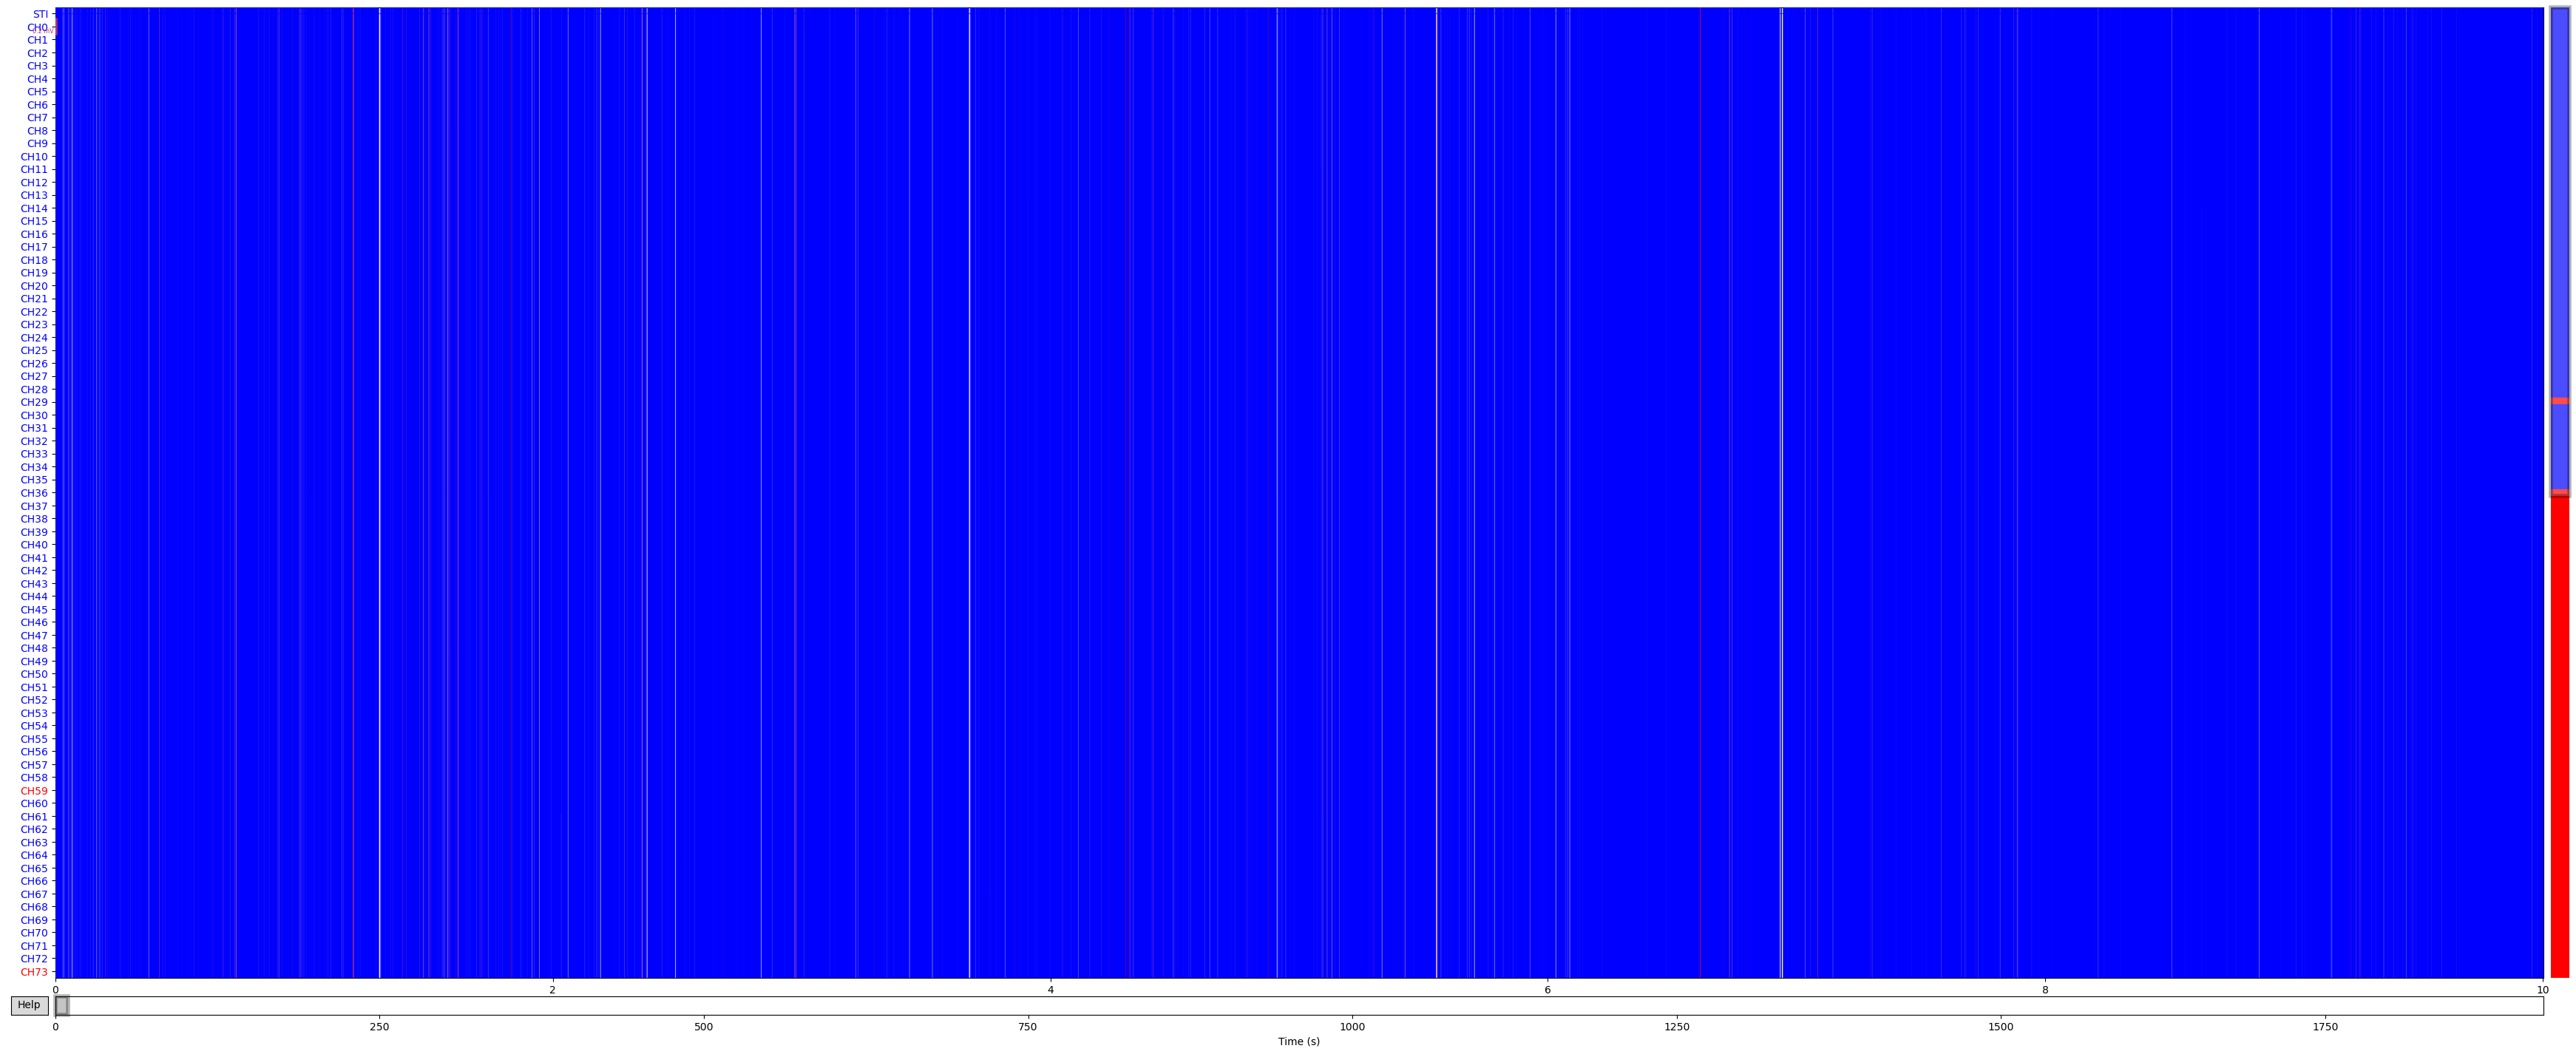

In [8]:
# plot for cleaning #
# filtered_notch_data.drop_channels(['CH59'])
filtered_notch_data.plot(events=events, color='b', bad_color = 'red', n_channels = 75, clipping = None, event_color = 'r')

Effective window size : 0.500 (s)


/tmp/ipykernel_66605/4029255160.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  filtered_notch_data.compute_psd().plot()


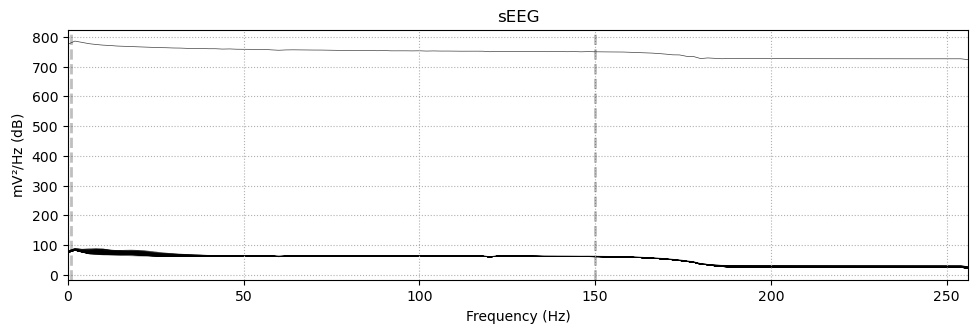

In [20]:
# plot psd of all channels #

filtered_notch_data.compute_psd().plot()

In [ ]:
# plot psd of bad channels #

filtered_notch_data.plot_psd(picks = filtered_notch_data.info['bads'])

## Bipolar Cleaning

Because the high frequency noise was so bad, Bob and I cleaned a bipolar version, but then I go back and exclude the single channels. Should be checked again in the preprocessing notebook.

In [9]:
# helper functions

def probe_and_num(elec_str): 
    ''' This convenience function takes an electrode string like LHH1 and outputs ('LHH', 1)
    '''
    if '_' in elec_str:
        return None, None
    else:   
        regex_str = '(\D+)(\d+)' # group of letters followed by group of digits
        matcher = re.compile(regex_str,re.IGNORECASE|re.DOTALL).search(elec_str)
        if matcher:
            probe, num = matcher.groups()
            return probe, int(num)
        else:
            return None, None
    
def find_bipolar_pair(ch, labels, remove):
    ''' Find the pair of a given electrode for bipolar referencing.
        Given a single *ch* and a list of *labels*, some of which you want to *remove*,
        this finds the next channel on that probe that isn't meant to be removed (WM is ok).
    '''
    bipolar_pair = None
    probe, num = probe_and_num(ch)
    other_in_probe = [other_ch for other_ch in labels if probe_and_num(other_ch)[0]==probe]
    for i in range(len(other_in_probe)-num):
        next_ch = probe + str(num+i+1)
        if next_ch in remove or next_ch == 'STI':
            continue
        else:
            bipolar_pair = next_ch
            break
    return bipolar_pair

In [10]:
filtered_clean_fif = filtered_notch_data.copy()

In [11]:
# Here I iterate through the electrodes in my ROIs and match them up with their bipolar pair
pairs = []
anode = []
cathode = []
pairs_name = []
pairs_map = {}
remove = filtered_clean_fif.info['bads']
labels = filtered_clean_fif.info['ch_names']
for ch in labels:
    # if a channel is meant to be removed, it doesn't get to be in a bipolar pair
    if ch in remove or ch == 'STI'or ch == 'CH147' or ch == 'CH72':
        print(f"{ch} noref")
    else:
        pair = find_bipolar_pair(ch, labels, remove)
        if pair:
            anode.append(ch)
            cathode.append(pair)
            pairs.append((ch, pair))
            pairs_map[ch] = f"{ch}-{pair}"
            pairs_name.append(f"{ch}-{pair}")
            print(ch, pair)

CH0 CH1
CH1 CH2
CH2 CH3
CH3 CH4
CH4 CH5
CH5 CH6
CH6 CH7
CH7 CH8
CH8 CH9
CH9 CH10
CH10 CH11
CH11 CH12
CH12 CH13
CH13 CH14
CH14 CH15
CH15 CH16
CH16 CH17
CH17 CH18
CH18 CH19
CH19 CH20
CH20 CH21
CH21 CH22
CH22 CH23
CH23 CH24
CH24 CH25
CH25 CH26
CH26 CH27
CH27 CH28
CH28 CH29
CH29 CH30
CH30 CH31
CH31 CH32
CH32 CH33
CH33 CH34
CH34 CH35
CH35 CH36
CH36 CH37
CH37 CH38
CH38 CH39
CH39 CH40
CH40 CH41
CH41 CH42
CH42 CH43
CH43 CH44
CH44 CH45
CH45 CH46
CH46 CH47
CH47 CH48
CH48 CH49
CH49 CH50
CH50 CH51
CH51 CH52
CH52 CH53
CH53 CH54
CH54 CH55
CH55 CH56
CH56 CH57
CH57 CH58
CH58 CH60
CH59 noref
CH60 CH61
CH61 CH62
CH62 CH63
CH63 CH64
CH64 CH65
CH65 CH66
CH66 CH67
CH67 CH68
CH68 CH69
CH69 CH70
CH70 CH71
CH71 CH72
CH72 noref
CH73 noref
CH74 noref
CH75 noref
CH76 noref
CH77 noref
CH78 noref
CH79 noref
CH80 noref
CH81 noref
CH82 noref
CH83 noref
CH84 noref
CH85 noref
CH86 noref
CH87 noref
CH88 noref
CH89 noref
CH90 noref
CH91 noref
CH92 noref
CH93 noref
CH94 noref
CH95 noref
CH96 noref
CH97 noref
CH98 noref
C

In [12]:
## Apply Rereference #
# load filtered data
filtered_clean_fif.load_data()

# set filtered reference 
bp_filt_fif = mne.set_bipolar_reference(filtered_clean_fif, anode = anode, cathode = cathode)
    


Reading 0 ... 982099  =      0.000 ...  1918.162 secs...
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=71, n_times=982100
    Range : 0 ... 982099 =      0.000 ...  1918.162 secs
Ready.


/home/brooke/anaconda3/envs/ieeg_analysis/lib/python3.9/site-packages/mne/io/reference.py:564: RuntimeWarning: invalid value encountered in matmul
  ref_data = multiplier @ inst._data


Added the following bipolar channels:
CH0-CH1, CH1-CH2, CH2-CH3, CH3-CH4, CH4-CH5, CH5-CH6, CH6-CH7, CH7-CH8, CH8-CH9, CH9-CH10, CH10-CH11, CH11-CH12, CH12-CH13, CH13-CH14, CH14-CH15, CH15-CH16, CH16-CH17, CH17-CH18, CH18-CH19, CH19-CH20, CH20-CH21, CH21-CH22, CH22-CH23, CH23-CH24, CH24-CH25, CH25-CH26, CH26-CH27, CH27-CH28, CH28-CH29, CH29-CH30, CH30-CH31, CH31-CH32, CH32-CH33, CH33-CH34, CH34-CH35, CH35-CH36, CH36-CH37, CH37-CH38, CH38-CH39, CH39-CH40, CH40-CH41, CH41-CH42, CH42-CH43, CH43-CH44, CH44-CH45, CH45-CH46, CH46-CH47, CH47-CH48, CH48-CH49, CH49-CH50, CH50-CH51, CH51-CH52, CH52-CH53, CH53-CH54, CH54-CH55, CH55-CH56, CH56-CH57, CH57-CH58, CH58-CH60, CH60-CH61, CH61-CH62, CH62-CH63, CH63-CH64, CH64-CH65, CH65-CH66, CH66-CH67, CH67-CH68, CH68-CH69, CH69-CH70, CH70-CH71, CH71-CH72


In [14]:
bp_filt_fif.save(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_bp-notclean-ieeg.fif", overwrite = True)

Writing /home/brooke/pacman/raw_data/LL17/ieeg/LL17_notched_filtered_bp-notclean-ieeg.fif


/tmp/ipykernel_7197/3722885680.py:1: RuntimeWarning: This filename (/home/brooke/pacman/raw_data/LL17/ieeg/LL17_notched_filtered_bp-notclean-ieeg.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_filt_fif.save(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_bp-notclean-ieeg.fif", overwrite = True)


Closing /home/brooke/pacman/raw_data/LL17/ieeg/LL17_notched_filtered_bp-notclean-ieeg.fif
[done]
Channels marked as bad:
['CH100', 'CH101', 'CH102', 'CH103', 'CH104', 'CH105', 'CH106', 'CH107', 'CH108', 'CH109', 'CH110', 'CH111', 'CH112', 'CH113', 'CH114', 'CH115', 'CH116', 'CH117', 'CH118', 'CH119', 'CH120', 'CH121', 'CH122', 'CH123', 'CH124', 'CH125', 'CH126', 'CH127', 'CH128', 'CH129', 'CH130', 'CH131', 'CH132', 'CH133', 'CH134', 'CH135', 'CH136', 'CH137', 'CH138', 'CH139', 'CH140', 'CH141', 'CH142', 'CH143', 'CH144', 'CH145', 'CH146', 'CH147', 'CH59', 'CH73', 'CH74', 'CH75', 'CH76', 'CH77', 'CH78', 'CH79', 'CH80', 'CH81', 'CH82', 'CH83', 'CH84', 'CH85', 'CH86', 'CH87', 'CH88', 'CH89', 'CH90', 'CH91', 'CH92', 'CH93', 'CH94', 'CH95', 'CH96', 'CH97', 'CH98', 'CH99']


In [9]:
bp_filt_fif = mne.io.Raw(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_bp-notclean-ieeg.fif")

Opening raw data file /home/brooke/pacman/raw_data/LL17/ieeg/LL17_notched_filtered_bp-notclean-ieeg.fif...
    Range : 0 ... 982099 =      0.000 ...  1918.162 secs
Ready.


/tmp/ipykernel_14061/3406638611.py:1: RuntimeWarning: This filename (/home/brooke/pacman/raw_data/LL17/ieeg/LL17_notched_filtered_bp-notclean-ieeg.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_filt_fif = mne.io.Raw(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_bp-notclean-ieeg.fif")


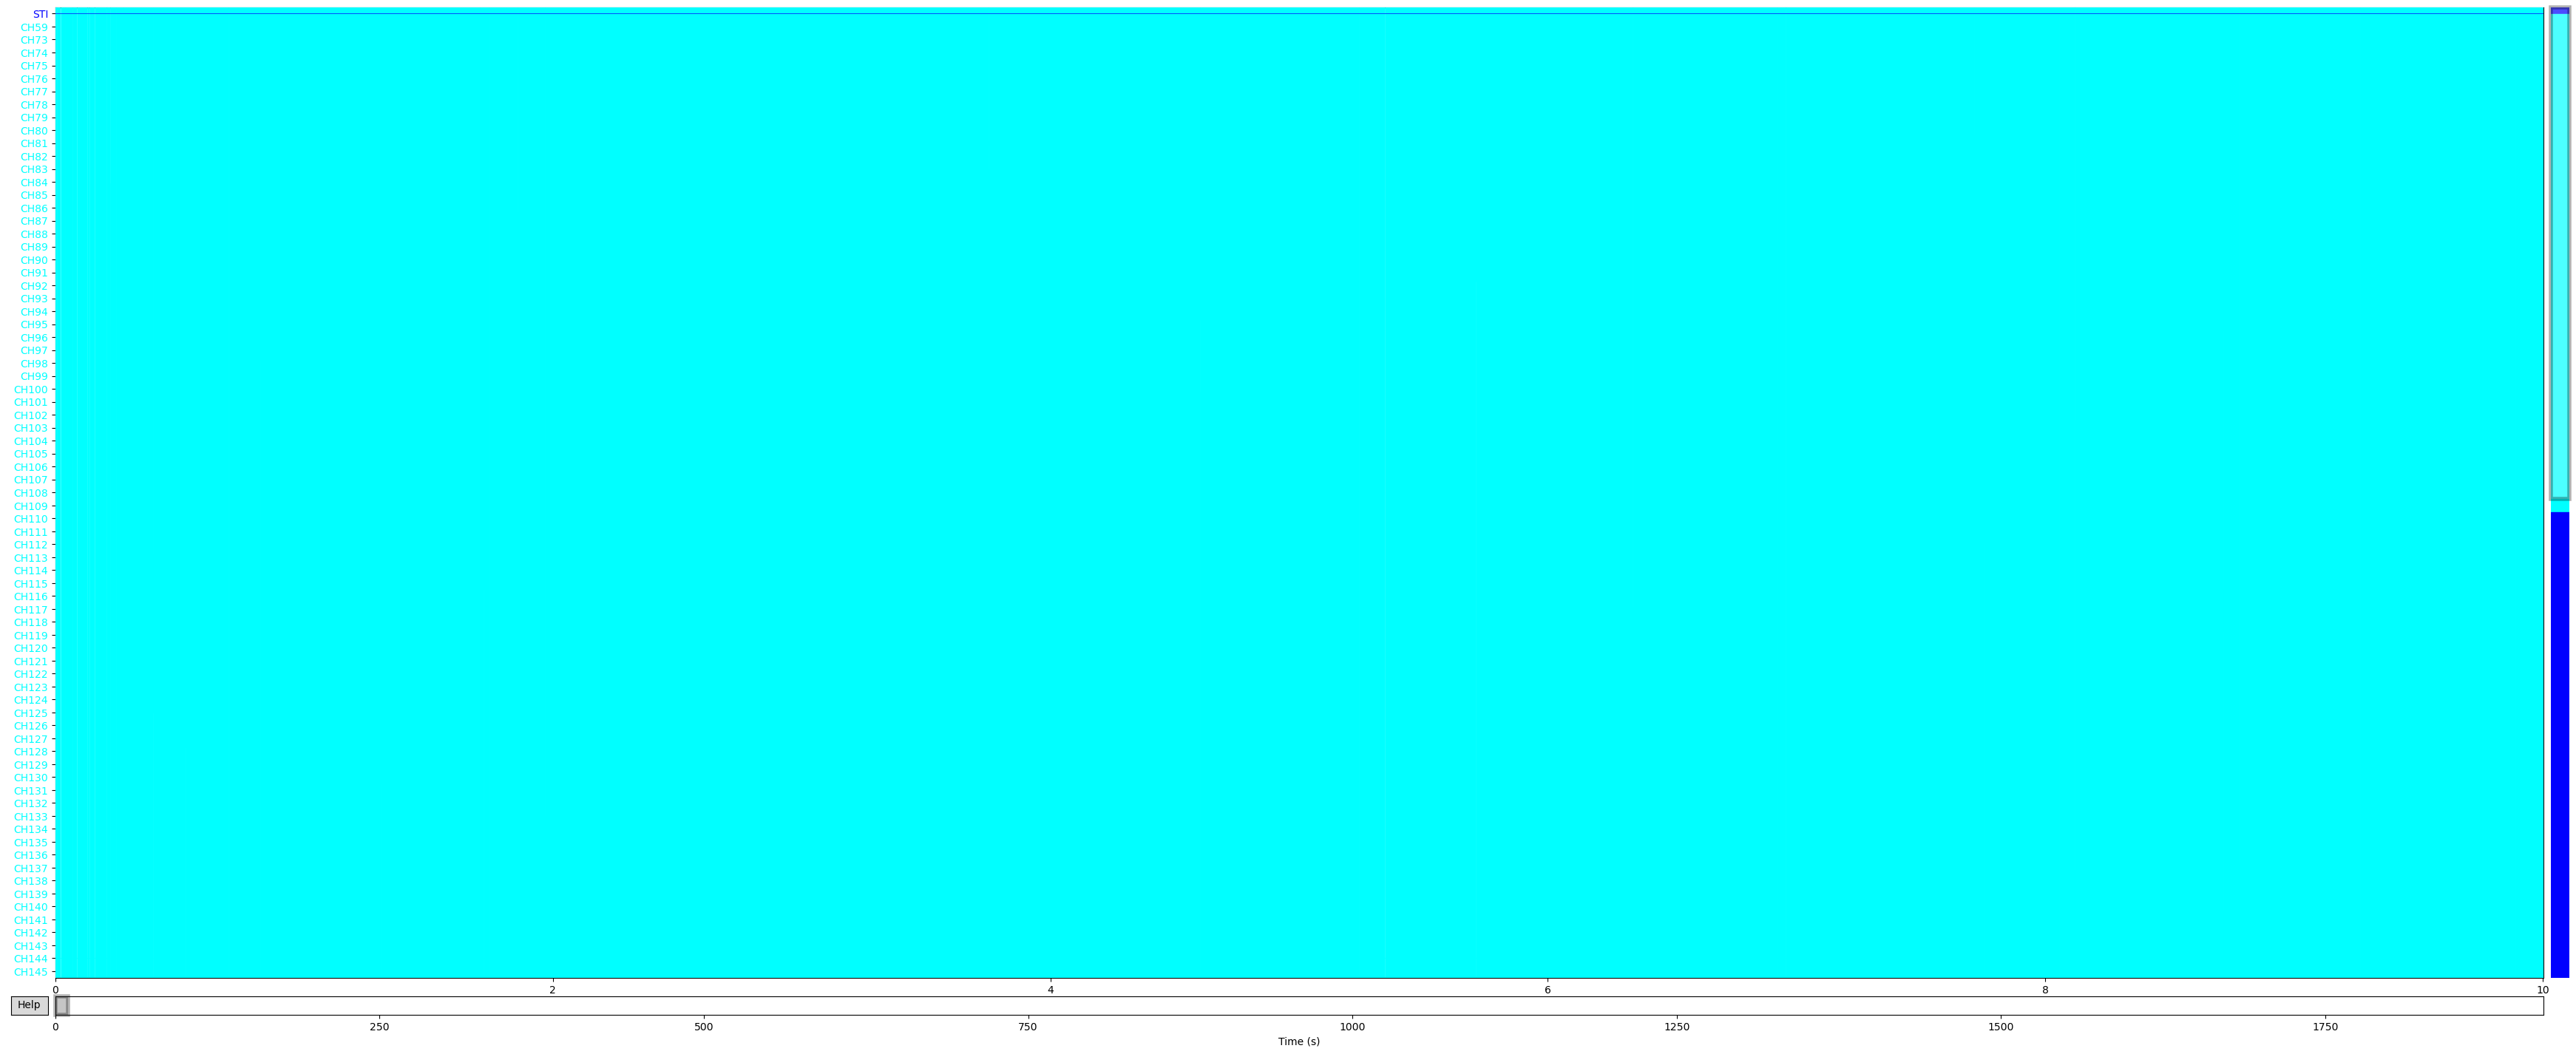

Channels marked as bad:
['CH100', 'CH101', 'CH102', 'CH103', 'CH104', 'CH105', 'CH106', 'CH107', 'CH108', 'CH109', 'CH110', 'CH111', 'CH112', 'CH113', 'CH114', 'CH115', 'CH116', 'CH117', 'CH118', 'CH119', 'CH120', 'CH121', 'CH122', 'CH123', 'CH124', 'CH125', 'CH126', 'CH127', 'CH128', 'CH129', 'CH130', 'CH131', 'CH132', 'CH133', 'CH134', 'CH135', 'CH136', 'CH137', 'CH138', 'CH139', 'CH140', 'CH141', 'CH142', 'CH143', 'CH144', 'CH145', 'CH146', 'CH147', 'CH59', 'CH73', 'CH74', 'CH75', 'CH76', 'CH77', 'CH78', 'CH79', 'CH80', 'CH81', 'CH82', 'CH83', 'CH84', 'CH85', 'CH86', 'CH87', 'CH88', 'CH89', 'CH90', 'CH91', 'CH92', 'CH93', 'CH94', 'CH95', 'CH96', 'CH97', 'CH98', 'CH99', 'CH22-CH23', 'CH14-CH15']


In [10]:
bp_filt_fif.plot(events=events, color='b', bad_color = 'cyan', n_channels = 75, clipping = None, event_color = 'r')

In [11]:
# # From interactive sessions
# interactive_annot = bp_filt_fif.annotations
# for x in range(0, len(bp_filt_fif.annotations)):
#     print(interactive_annot[x])
    
    
# filtered_notch_data.annotations.save('../ieeg/saved_annotations.fif', overwrite = True) 

/tmp/ipykernel_14061/3822876132.py:7: RuntimeWarning: This filename (../ieeg/saved_annotations.fif) does not conform to MNE naming conventions. All annotations files should end with -annot.fif, -annot.fif.gz, _annot.fif, _annot.fif.gz, .txt or .csv
  filtered_notch_data.annotations.save('../ieeg/saved_annotations.fif', overwrite = True)


## Save Files

In [14]:
# save filtered data #
filtered_notch_data.save(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_clean_ieeg.fif", overwrite = True)


# save raw clean data #
raw_fif.save(f"{raw_data_dir}/ieeg/{subject}_raw_clean_ieeg.fif", overwrite = True)


Overwriting existing file.
Writing /home/brooke/pacman/raw_data/LL17/ieeg/LL17_notched_filtered_clean_ieeg.fif
Closing /home/brooke/pacman/raw_data/LL17/ieeg/LL17_notched_filtered_clean_ieeg.fif
[done]
Overwriting existing file.
Writing /home/brooke/pacman/raw_data/LL17/ieeg/LL17_raw_clean_ieeg.fif
Closing /home/brooke/pacman/raw_data/LL17/ieeg/LL17_raw_clean_ieeg.fif
[done]
